# Autocodificadores

Fazer um jupyter notebook com autocodificador, a exemplo do exemplo mostrado em aula usando o Keras:

- https://t-adessowiki.fee.unicamp.br/user/aluno/notebooks/ia368z_2s2017/ia368z/deliver-keras/DenseAutoencoder.ipynb

Com as seguintes modificações:

- Utilizar o PyTorch
- Se possível, utilizar um autocodificador convolucional, porém não é imperativo
- Uma vez que o autocodificador seja treinado e o espaço bidimensional seja mostrado dos códigos dos dígitos da base de dados NMIST, gerar novas imagens:
  - mostrar algumas imagens em pontos quaisquer neste espaço bidimensional
  - dados dois pontos neste espaço, mostrar várias imagens, começando no ponto 1 e caminhando numa reta que une os dois pontos, gerar imagens associadas a pontos igualmente espaçados nessa reta, até chegar ao segundo ponto. É se esperar que os números gerados sejam interpolados entre eles.

In [199]:
import torch
import torchvision
import numpy as np

from torch.autograd import Variable
import torch.nn as nn
from collections import OrderedDict

from PIL import Image
from IPython import display

import matplotlib.pyplot as plt

## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [200]:
data_train = torchvision.datasets.MNIST('datasets/MNIST/', train=True, download=True)
data_test  = torchvision.datasets.MNIST('datasets/MNIST/', train=False)

In [201]:
len(data_train), len(data_test)

(60000, 10000)

In [202]:
data_train.train_data.shape, data_test.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Treinando com pouquíssimos dados

In [203]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
    data_train.train_data = data_train.train_data[:n_train_samples]
    data_test.test_data   = data_test.test_data[:n_test_samples]

In [204]:
data_train.train_data.shape, data_test.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Visualizando algumas amostras

In [205]:
for k,(x,y) in enumerate(data_test):
    display.display(x)
    print('label=',y)
    if k > 2:
        break

label= 7


label= 2


label= 1


label= 0


In [206]:
class DeepNetTrainer:
    
    def __init__(self, file_basename=None, model=None, criterion=None, metrics=None, 
                 optimizer=None, lr_scheduler=None, reset=False):
        assert (model is not None) and (criterion is not None) and (optimizer is not None)
        self.basename = file_basename
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = lr_scheduler
        self.metrics = dict(train=dict(losses=[]), valid=dict(losses=[]))
        self.compute_metric = dict()
        
        if metrics is not None:
            for name, funct in metrics.items():
                self.metrics['train'][name] = []
                self.metrics['valid'][name] = []
                self.compute_metric[name] = funct
        
        if (self.basename is not None) and (not reset) and (os.path.isfile(self.basename + '.model')):
            self.load_trainer_state(self.basename, self.model, self.optimizer, self.metrics)
            print('Model loaded from', self.basename + '.model')
            
        self.last_epoch = len(self.metrics['train']['losses'])
        if self.scheduler is not None:
            self.scheduler.last_epoch = self.last_epoch
            
    def fit(self, n_epochs, train_data, valid_data=None, use_gpu='auto'):
        data = dict(train=train_data, valid=valid_data)
        if valid_data is None:
            phases = [('train', True)]
        else:
            phases = [('train', True), ('valid', False)]
     
        if use_gpu == 'auto':
            use_gpu = torch.cuda.is_available()
        assert use_gpu == False or use_gpu == True
            
        try:
            print('Starting training for {} epochs\n'.format(n_epochs))

            best_epoch = self.last_epoch
            best_loss = 1e10
            if self.last_epoch > 0:
                best_loss = self.metrics['valid']['losses'][-1] or self.metrics['train']['losses'][-1]
                self.print_losses(self.last_epoch)

            for i in range(self.last_epoch + 1, self.last_epoch + n_epochs + 1):
                t0 = time.time()
                
                for phase, is_train in phases:
                
                    epo_samp = 0
                    epo_loss = 0
                    epo_metrics = dict([(n, 0) for n in self.compute_metric.keys()])
                    
                    self.model.train(is_train)
                    if is_train and self.scheduler is not None:
                        self.scheduler.step()

                    for ii, (X, Y) in enumerate(data[phase]):
                        if use_gpu:
                            X, Y = Variable(X.cuda()), Variable(Y.cuda())
                        else:
                            X, Y = Variable(X), Variable(Y)

                        Ypred = self.model.forward(X)
                        loss = self.criterion(Ypred, Y)
                        if is_train:
                            self.optimizer.zero_grad()
                            loss.backward()
                            self.optimizer.step()

                        epo_loss += loss.data.cpu().numpy()
                        epo_samp += 1

                        for name, fun in self.compute_metric.items():
                            metric = fun(Ypred, Y)
                            epo_metrics[name] += metric

                    eloss = float(epo_loss / epo_samp)
                    self.metrics[phase]['losses'].append(eloss)
                    
                    for name, fun in self.compute_metric.items():
                        metric = float(epo_metrics[name] / epo_samp)
                        self.metrics[phase][name].append(metric)

                if valid_data is None:
                    self.metrics['valid']['losses'].append(None)
                    for name, fun in self.compute_metric.items():
                        self.metrics['valid'][name].append(None)
                        
                is_best = ''
                if eloss < best_loss:
                    is_best = 'best'
                    best_loss = eloss
                    best_epoch = i
                    if self.basename is not None:
                        self.save_trainer_state(self.basename, self.model, self.optimizer, self.metrics)

                self.print_losses(i, t0, is_best)
                t0 = time.time()

        except KeyboardInterrupt:
            print('Interrupted!!')

        print('\nModel from epoch {} saved as "{}.*", loss = {:.5f}'.format(best_epoch, self.basename, best_loss))

    def print_losses(self, i, t0=0, is_best='best'):
        has_valid = self.metrics['valid']['losses'][-1] is not None
        has_metrics = len(self.compute_metric) > 0
        etime = 0
        if t0 > 0:
            etime = time.time() - t0
        if has_valid and has_metrics:
            # validation and metrics
            mtrc = list(self.compute_metric.keys())[0]
            print('{:3d}: {:5.1f}s   T: {:.5f} {:.5f}   V: {:.5f} {:.5f} {}'
                  .format(i, etime,
                          self.metrics['train']['losses'][-1], self.metrics['train'][mtrc][-1],
                          self.metrics['valid']['losses'][-1], self.metrics['valid'][mtrc][-1], is_best))
        elif has_valid:
            # validation and no metrics
            print('{:3d}: {:5.1f}s   T: {:.5f}   V: {:.5f} {}'
                  .format(i, etime, self.metrics['train']['losses'][-1],
                                               self.metrics['valid']['losses'][-1], is_best))
        elif not has_valid and has_metrics:
            # no validation and metrics
            mtrc = list(self.compute_metric.keys())[0]
            print('{:3d}: {:5.1f}s   T: {:.5f} {:.5f} {}'
                  .format(i, etime, self.metrics['train']['losses'][-1],
                                               self.metrics['train'][mtrc][-1], is_best))
        else:
            # no validation and no metrics
            print('{:3d}: {:5.1f}s   T: {:.5f} {}'
                  .format(i, etime - t0, self.metrics['train']['losses'][-1], is_best))

    def predict(self, data_loader):
        predictions = []
        try:
            self.model.train(False)  # Set model to evaluate mode
            for ii, (image, labels) in enumerate(data_loader):
                if use_gpu:
                    image = Variable(image.cuda())
                else:
                    image = Variable(image)
                outputs = self.model.forward(image)
                predictions.append(outputs.data.cpu())
                print('\rpredict: {}'.format(ii), end='')
            print(' ok')
        except KeyboardInterrupt:
            print(' interrupted!')
        finally:
            if len(predictions) > 0:
                return torch.cat(predictions, 0)

    def evaluate(self, data_loader, metrics=None):
        n_batches = 0
        try:
            if metrics is None:
                metric_dict = self.compute_metric
            else:
                metric_dict = metrics
            epo_metrics = {}
            for name in metric_dict.keys():
                epo_metrics[name] = 0
            self.model.train(False)  # Set model to evaluate mode
            for ii, (X, Y) in enumerate(data_loader):
                if use_gpu:
                    X, Y = Variable(X.cuda()), Variable(Y.cuda())
                else:
                    X, Y = Variable(X), Variable(Y)
                Ypred = self.model.forward(X)
                for name, fun in metric_dict.items():
                    vmetric = fun(Ypred, Y)
                    epo_metrics[name] += vmetric
                n_batches += 1
                print('\revaluate: {}'.format(ii), end='')
            print(' ok')
        except KeyboardInterrupt:
            print(' interrupted!')
        finally:
            if n_batches > 0:
                for name in epo_metrics.keys():
                    epo_metrics[name] /= n_batches
                return epo_metrics

    @staticmethod
    def load_trainer_state(file_basename, model, optimizer, metrics):
        model.load_state_dict(torch.load(file_basename + '.model'))
        # if os.path.isfile(file_basename + '.optim'):
        #     optimizer.load_state_dict(torch.load(file_basename + '.optim'))
        if os.path.isfile(file_basename + '.histo'):
            metrics.update(pickle.load(open(file_basename + '.histo', 'rb')))
    
    @staticmethod
    def save_trainer_state(file_basename, model, optimizer, metrics):
        torch.save(model.state_dict(), file_basename + '.model')
        # torch.save(optimizer.state_dict(), file_basename + '.optim')
        pickle.dump(metrics, open(file_basename + '.histo', 'wb'))


## Prepara input e ouput da rede

In [207]:
from torch.utils.data import Dataset
import torchvision.transforms as trans

class AutoEncoderDataset(Dataset):
    def __init__(self, input_data, labels_data):
        super(AutoEncoderDataset, self).__init__()
        
        self.input_data = input_data.view(-1, 28, 28).type(torch.FloatTensor) / 255.0
        self.labels_data = labels_data
        
    def __len__(self):
        return self.input_data.size(0)
    
    def __getitem__(self, i):
        data = self.input_data[i]
        return (data, data)
    
    def get_label(self, i):
        return self.labels_data[i]

In [209]:
ae_data_train = AutoEncoderDataset(data_train.train_data, data_train.train_labels)
ae_data_test  = AutoEncoderDataset(data_test.test_data, data_test.test_labels)

print(len(ae_data_train))
print(len(ae_data_test))

60000
10000


## Cria os DataLoaders

In [211]:
from torch.utils.data import DataLoader

dataloaders = {
    'train': DataLoader(ae_data_train, batch_size=20, shuffle=True, num_workers=4),
    'val': DataLoader(ae_data_test, batch_size=20, shuffle=False, num_workers=4),
}

## Cria a rede

In [267]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super(MyAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(28*28, 512)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(512, 128)),
            ('relu2', nn.ReLU()),
            ('dense3', nn.Linear(128, 2))
        ]))
        
        self.decoder = nn.Sequential(OrderedDict([
            ('dense3', nn.Linear(2, 128)),
            ('relu2', nn.ReLU()),
            ('dense2', nn.Linear(128, 512)),
            ('relu1', nn.ReLU()),
            ('dense1', nn.Linear(512, 28*28))
        ]))
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 28, 28)
        
        return x

## Cria o trainer

In [268]:
from torch.optim import lr_scheduler

model = MyAutoEncoder()
model.cuda()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)

trainer = DeepNetTrainer('./auto_encoder', model, criterion, optimizer=optimizer,
                        lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                        reset=True)

In [269]:
import time, pickle
trainer.fit(n_epochs=10, train_data=dataloaders['train'], valid_data=dataloaders['val'])

Starting training for 10 epochs

  1:  13.1s   T: 0.04575   V: 0.04191 best
  2:  13.1s   T: 0.04105   V: 0.04014 best
  3:  13.4s   T: 0.03975   V: 0.03906 best
  4:  13.3s   T: 0.03906   V: 0.03871 best
  5:  13.1s   T: 0.03843   V: 0.03817 best
  6:  13.2s   T: 0.03792   V: 0.03800 best
  7:  13.1s   T: 0.03637   V: 0.03643 best
  8:  13.1s   T: 0.03604   V: 0.03629 best
  9:  13.0s   T: 0.03586   V: 0.03617 best
 10:  13.6s   T: 0.03570   V: 0.03614 best

Model from epoch 10 saved as "./auto_encoder.*", loss = 0.03614


In [272]:
test_dl = DataLoader(ae_data_test, batch_size=10, shuffle=True, num_workers=4)
iterador = iter(test_dl)

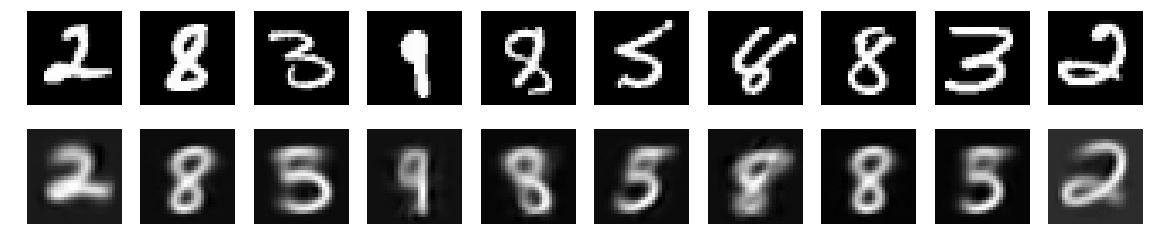

In [273]:
inputs, _ = next(iterador)
out = model(Variable(inputs.cuda()))

n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(inputs[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()


## Imagens no plano 2D

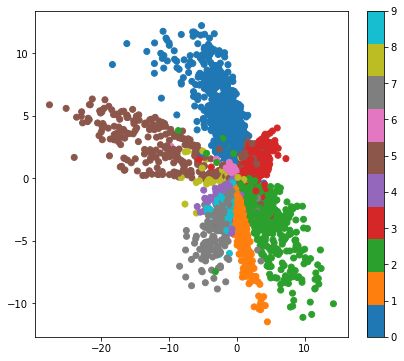

In [274]:
batch_size = 20
test_dl = DataLoader(ae_data_test, batch_size=batch_size, shuffle=False, num_workers=4)

encoded_data = np.zeros((len(ae_data_test), 2))
for i, (data, _) in enumerate(test_dl):
    inputs = data.view(-1, 28*28)
    encoded = model.encoder(Variable(inputs.cuda()))
    encoded_data[i*batch_size:(i+1)*batch_size] = encoded.data.cpu().numpy()

plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=ae_data_test.labels_data.numpy(), cmap=plt.cm.tab10)
plt.colorbar();
plt.show()

## transformação na imagem ao percorrer uma linha no espaço 2D

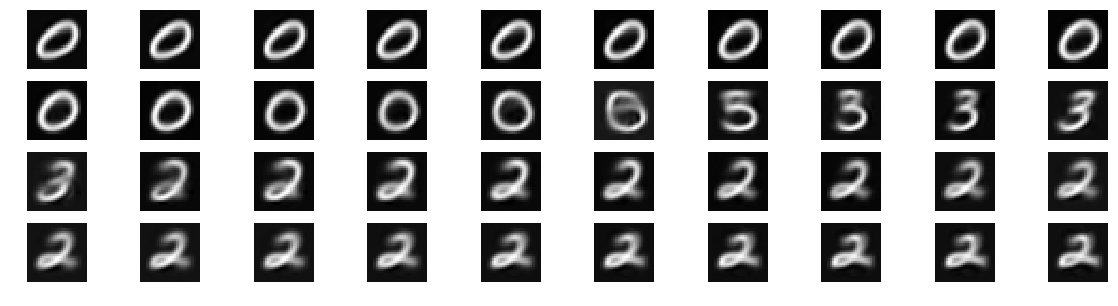

In [280]:
n = 40
x = np.linspace(-5.0, 10.0, n)
y = np.linspace(10.0, -10.0, n)

data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

out = model.decoder(Variable(data.cuda()))
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()